#About the dataset and the task:
##The dataset contains 27558 images of malaria infected and uninfected cells.
##With a Neural Network we try to distinguish between images of these two categories.

In [1]:
#First, I import the necessary libraries:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential

In [6]:
#Loading the dataset from the tensorflow dataset library
train, info = tfds.load('malaria', split='train', shuffle_files=True, as_supervised=True, with_info= True)

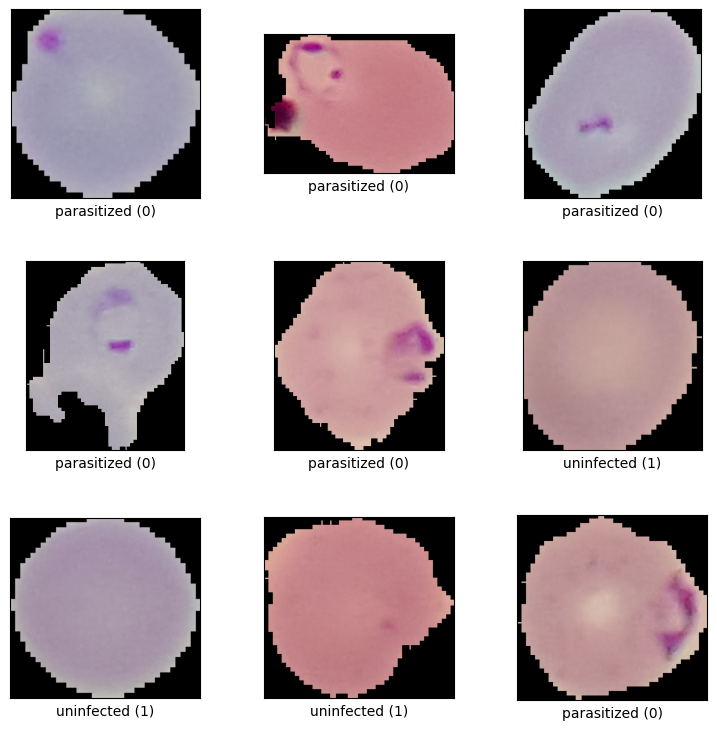

In [13]:
#let's get a view of our dataset with a vizualization
vis = tfds.visualization.show_examples(train, info)

In [7]:
#Loading the dataset from the tensorflow dataset library again without the info ad also splitting the data into train and test set
train, test = tfds.load('malaria', split=['train[:80%]', 'train[80%:]'], shuffle_files=True, as_supervised=True)

In [3]:
#Inspecting the number of training and testing examples
train_images = tf.data.experimental.cardinality(train).numpy()
print("Num training images: " + str(train_images))
test_images = tf.data.experimental.cardinality(test).numpy()
print("Num testing images: " + str(test_images))

Num training images: 22046
Num testing images: 5512


In [4]:
#Let's see an example of the shape of one of the images in the dataset
for image, label in train.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (103, 103, 3)
Label:  1


In [8]:
#We can see that our data has 2 classes (is binary)
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


In [9]:
#We write the "resize" and the "convert" functions to turn all the pixels between 0 and one and turn the images to the appropriat size to make it easier for processing
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def resize(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 150, 150)
  return image,label

In [10]:
pad_train = (train.cache().map(resize).batch(32))
pad_test = (test.cache().map(resize).batch(32))

In [11]:
#We can use the weights of a pretrianed model which have been trained on million images and is more efficient and better designed
#here, we use the inception model which is a well-known model that has trained on million images (you can find the documentation on the tensorflow and keras website)
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
#We dont train the layers in the pretrained model so we write layer.trainable = False for every layer in the model
for layer in inception_model.layers:
  layer.trainable = False
#we want to see the models summary to get a good look into the layers of the model and also to find the last layer of the model before the dense layers
inception_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [12]:
last_layer = inception_model.get_layer('mixed7')
output = last_layer.output

In [13]:
#We use the output of the last layer of t he pretrained model and feed into other layers that we can with the use of functional API
h = layers.Flatten()(output)
h = layers.Dense(1024, activation='relu')(h)
h = layers.Dropout(0.2)(h)
h = layers.Dense(1, activation='sigmoid')(h)
model = Model(inception_model.input, h)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [14]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(pad_train, epochs=4, validation_data=pad_test, batch_size=128)

Epoch 1/4
689/689 [==============================] - 890s 1s/step - loss: 0.3510 - accuracy: 0.9047 - val_loss: 0.2331 - val_accuracy: 0.9173
Epoch 2/4
689/689 [==============================] - 884s 1s/step - loss: 0.1662 - accuracy: 0.9385 - val_loss: 0.1829 - val_accuracy: 0.9352
Epoch 3/4
689/689 [==============================] - 893s 1s/step - loss: 0.1411 - accuracy: 0.9502 - val_loss: 0.1616 - val_accuracy: 0.9441
Epoch 4/4
689/689 [==============================] - 891s 1s/step - loss: 0.1249 - accuracy: 0.9550 - val_loss: 0.2163 - val_accuracy: 0.9338


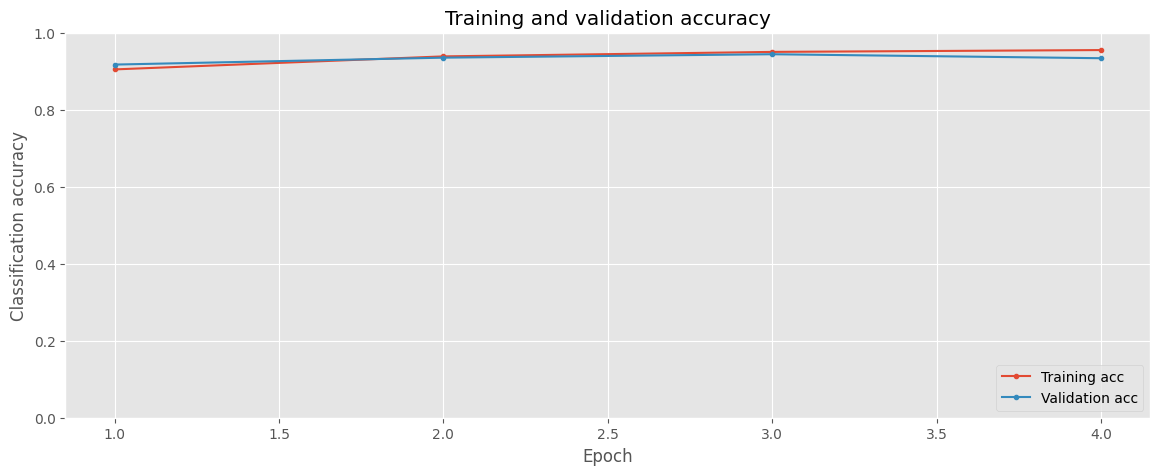

In [15]:
#Finnaly, we can plot our model's perfomance on the training and hold out validation set to see if we need to make a change
plt.style.use('ggplot')
history_dict = history.history
acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);